Loading data... Done
Batch 1/2
Batch 2/2
IoU_0: 0.9245
IoU_1: 0.9856
IoU_2: 0.6265
IoU_3: 0.4146
IoU_4: 0.3376
IoU_5: 0.0000
IoU_6: 0.5550
IoU_7: 0.3528
IoU_8: 0.3442
IoU_9: 0.2815
IoU_10: 0.0000
IoU_11: 0.0000
IoU_12: 0.4122

Mean IoU: 0.4026
Overall Accuracy: 0.8368


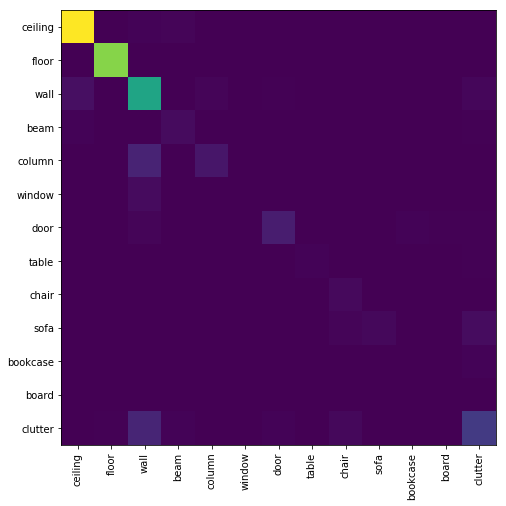

In [3]:
import torch
import numpy as np
import sklearn
import os, random, multiprocessing
import matplotlib.pyplot as plt
import trimesh
from architecture import PointNetSegmentation


print('Loading data... ', end='')
cats = ['ceiling', 'floor', 'wall', 'beam', 'column', 'window', 'door', 'table', 'chair', 'sofa', 'bookcase', 'board', 'clutter']
data_dir = '../dataset/S3DIS'
f = np.load(os.path.join(data_dir, 'data_test.npz'))
data, labels = sklearn.utils.shuffle(f['data'], f['labels'], random_state=19260817)
in_features = data.shape[1]
batch_size = 32

if not torch.cuda.is_available():
    data = data[:2*batch_size, ...]
    labels = labels[:2*batch_size, ...]

# zero-center xyz and rgb
data[:, :6, :] -= np.mean(data[:, :6, :], axis=2, keepdims=True)
# zero-center location
data[:, 6:, :] = data[:, 6:, :] * 2.0 - 1.0

X = torch.from_numpy(data.astype(np.float32))
t = torch.from_numpy(labels.astype(np.int64))

print('Done')


if torch.cuda.is_available():
    pn_segment = PointNetSegmentation(in_features=in_features, num_classes=13).cuda()
    pn_segment.load_state_dict(torch.load('../results/segmentation/93.40/PointNetSegment.pt'))
else:
    pn_segment = PointNetSegmentation(in_features=in_features, num_classes=13)
    pn_segment.load_state_dict(torch.load('../results/segmentation/93.40/PointNetSegment.pt', map_location=lambda storage, location: storage))


pn_segment.train(False)
num_batches = X.shape[0] // batch_size
C = np.zeros((13, 13))
y = []
for bn in range(num_batches):
    print('Batch {}/{}'.format(bn + 1, num_batches))
    X_batch = torch.autograd.Variable(X[bn * batch_size: bn * batch_size + batch_size, ...])
    t_batch = t[bn * batch_size: bn * batch_size + batch_size, ...]
    if torch.cuda.is_available():
        X_batch = X_batch.cuda()
        t_batch = t_batch.cuda()
    y_batch = pn_segment(X_batch)[0].data.max(1)[1]
    y.append(y_batch.cpu().numpy())
    for i in range(13):
        for j in range(13):
            C[i, j] += np.logical_and(t_batch == i, y_batch == j).sum()

IoU = np.zeros(13)
for i in range(13):
    IoU[i] = C[i, i] / (C[i, :].sum() + C[:, i].sum() - C[i, i])
    print('IoU_{}: {:.4f}'.format(i, IoU[i]))
print('\nMean IoU: {:.4f}'.format(IoU.mean()))
print('Overall Accuracy: {:.4f}'.format(np.diag(C).sum() / C.sum()))


plt.figure(figsize=(8,8))
plt.imshow(C)
plt.xticks(np.arange(len(cats)), cats, rotation='vertical')
plt.yticks(np.arange(len(cats)), cats)
plt.show()


cat2clr = {'ceiling':     [0,255,0],
           'floor':       [0,0,255],
           'wall':        [0,255,255],
           'beam':        [255,255,0],
           'column':      [255,0,255],
           'window':      [100,100,255],
           'door':        [200,200,100],
           'table':       [170,120,200],
           'chair':       [255,0,0],
           'sofa':        [200,100,100],
           'bookcase':    [10,200,100],
           'board':       [200,200,200],
           'clutter':     [50,50,50]}
lab2clr = [cat2clr[c] for c in cats]

X_test = np.transpose(X.numpy(), (0, 2, 1)) # num_images x num_points x 9
y_test = np.concatenate(y, axis=0) # num_images x num_points
t_test = t[:y_test.shape[0]].numpy()

In [7]:
# i = random.randrange(y_test.shape[0])
i = 56
points1 = trimesh.points.PointCloud(vertices = X_test[i, :, :3], color = list(map(lambda x : lab2clr[x], y_test[i, :])))
points2 = trimesh.points.PointCloud(vertices = X_test[i, :, :3], color = list(map(lambda x : lab2clr[x], t_test[i, :])))

processes = [multiprocessing.Process(target=points1.show), multiprocessing.Process(target=points2.show)]
for p in processes:
    p.start()
for p in processes:
    p.join()

In [5]:
points = cloud.get_sample("mesh_random_sampling", n=1024)


In [9]:
type(points)

pandas.core.frame.DataFrame

In [7]:
new_cloud = pyntcloud.PyntCloud(points)
new_cloud.plot()

In [5]:
# load train file paths
paths = [(root, filename) for root, _, files in os.walk(dataset, topdown=False) for filename in files if
         dataset_type in root and '.off' in filename]

data, labels = [], []
for i, (root, filename) in enumerate(paths):
    file_dir = os.path.join(root, filename)
    with open(file_dir, 'r') as f:
        lines = f.readlines()
        f.close()
    if lines[0].strip() != 'OFF':
        lines[0] = lines[0].replace('OFF', '')
        lines = ['OFF\n'] + lines
        with open(file_dir, 'w') as f:
            f.writelines(lines)
            f.close()

    mesh = trimesh.load(file_dir)
    samples = sample_surface(mesh, num_points)[0]  # num_points x 3
    data.append(samples)
    labels.append(cat2lab[root.split('/')[-2]])

data = np.array(data)  # np.array: num_images x num_points x 3

# zero-center
data -= np.mean(data, axis=1, keepdims=True)

# normalize
data /= np.max(np.linalg.norm(data, ord=2, axis=2, keepdims=True), axis=1, keepdims=True)